# Strip search and coregistraion

> This notebook is [available on GitHub here.](https://github.com/trchudley/pdemtools/blob/main/notebooks/strip_search_and_dem_difference.ipynb)

Here, we describe how we can use `pdemtools` to search for, and download, ArcticDEM and REMA strips. We also coregister them, allowing for simple change analysis to be performed.

First, we must import `pdemtools`, in addition to the in-built `os` function for file management and `matplotlib` to plot our results in this notebook.

In [1]:

import os

import pdemtools as pdt

import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

%matplotlib inline


We will also need to provide the local location of the ArcticDEM strip index and ArcticDEM bedmachine product. These do not need to be in any specific directory - just provide the complete filepath as a string.

In [2]:

index_fpath = '.../ArcticDEM_Strip_Index_s2s041.parquet'
bm_fpath = '.../BedMachineGreenland-v5.nc'


## Searching for strips

For the example here, let's example recent surface elevation change across KIV Steenstrups Nordre Bræ (where we know [significant change occurred between 2016 and 2021](https://doi.org/10.1038/s41467-023-37764-7)).

Let's set an appropriate bounding box (in EPSG:3413 / Polar Stereographic North*), and set further filtering choices to limit our options to high-quality, summer scenes that cover at least 70% of the bounding box.

*Note that pDEMtools currently only accepts bounds in the same format as the ArcticDEM/REMA datasets themselves: that is say, the Polar Stereographic projections (EPSG:3413 for the north/ArcticDEM and EPSG:3031 for the south/REMA).



In [3]:

bounds = (459000, -2539000, 473000, -2528000)

gdf = pdt.search(
    index_fpath, 
    bounds, 
    dates = '20170101/20221231',
    months = [6,7,8,9],
    years = [2017,2021],
    baseline_max_hours = 24,
    sensors=['WV03', 'WV02', 'WV01'],
    accuracy=2,
    min_aoi_frac = 0.7,
)

gdf = gdf.sort_values('acqdate1')

print(f'{len(gdf)} strips found')


6 strips found


The `pdt.search()` function returns a `geopandas` geodataframe, which we can visualise as with any other dataframe:

In [4]:
gdf[['dem_id', 'acqdate1', 'acqdate2']]

,dem_id,acqdate1,acqdate2
175143,SETSM_s2s041_WV01_20170607_1020010063D4CE00_10...,2017-06-07 16:36:42+00:00,2017-06-07 16:37:31+00:00
175148,SETSM_s2s041_WV01_20170624_1020010060B7D000_10...,2017-06-24 16:35:53+00:00,2017-06-24 16:36:43+00:00
175138,SETSM_s2s041_WV03_20170728_104001002E870C00_10...,2017-07-28 14:06:24+00:00,2017-07-28 14:05:24+00:00
175116,SETSM_s2s041_WV02_20170829_103001006F1D6400_10...,2017-08-29 14:23:03+00:00,2017-08-29 14:21:43+00:00
175106,SETSM_s2s041_WV03_20210715_104001006A09A000_10...,2021-07-15 13:56:37+00:00,2021-07-15 13:55:42+00:00
175144,SETSM_s2s041_WV02_20210731_10300100C359CF00_10...,2021-07-31 14:10:48+00:00,2021-07-31 14:09:25+00:00


There's still no guarantee that these scenes will be of high quality - so we can make use of the `load.preview()` function to download a 10 m hillshade that will help us quickly asses strip quality. Note that we can rerun this cell repeatedly, changing the value of `i` to a different index number to previous different scenes.

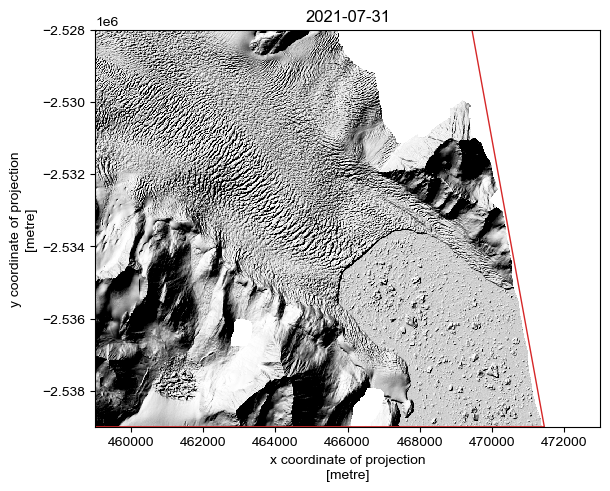

In [5]:

# =================
# SCENE TO PREVIEW
i = 5
# =================

preview = pdt.load.preview(gdf.iloc[[i]], bounds)

fig, ax = plt.subplots(layout='constrained')
preview.plot(cmap='Greys_r', add_colorbar=False)

gdf.iloc[[i]].plot(ax=ax, fc='none', ec='tab:red')

ax.set_title(gdf.iloc[[i]].acqdate1.dt.date.values[0])
plt.show()


By examining the individual strips one-by-one, we can manually identify the optimal scenes for our purpose. Here, I have selected the second and sixth strips (index positions 1 and 5)

In [6]:
selected_scenes = [1, 5]

Let's save the selected scenes as a geopackage, so we can return to this later:

In [7]:
if not os.path.exists('example_data'):
    os.mkdir('example_data')

In [8]:
gdf_sel = gdf.iloc[selected_scenes]

gdf_sel.to_file(os.path.join('example_data', 'scenes.gpkg'))

gdf_sel

,fid,dem_id,pairname,stripdemid,sensor1,sensor2,catalogid1,catalogid2,acqdate1,acqdate2,...,fileurl,s3url,geom,pdt_time1,pdt_time2,pdt_dem_baseline_hours,pdt_time_mean,pdt_year,pdt_month,pdt_aoi_frac
175148,175149,SETSM_s2s041_WV01_20170624_1020010060B7D000_10...,WV01_20170624_1020010060B7D000_1020010063B5E200,WV01_20170624_1020010060B7D000_1020010063B5E20...,WV01,WV01,1020010060B7D000,1020010063B5E200,2017-06-24 16:35:53+00:00,2017-06-24 16:36:43+00:00,...,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,"POLYGON ((459000 -2539000, 459000 -2528000, 47...",2017-06-24 16:35:53+00:00,2017-06-24 16:36:43+00:00,0.0,2017-06-24 16:36:18+00:00,2017,6,1.000000
175144,175145,SETSM_s2s041_WV02_20210731_10300100C359CF00_10...,WV02_20210731_10300100C359CF00_10300100C37C8000,WV02_20210731_10300100C359CF00_10300100C37C800...,WV02,WV02,10300100C359CF00,10300100C37C8000,2021-07-31 14:10:48+00:00,2021-07-31 14:09:25+00:00,...,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,"POLYGON ((471450.48 -2539000, 459000 -2539000,...",2021-07-31 14:10:48+00:00,2021-07-31 14:09:25+00:00,1.0,2021-07-31 14:10:06.500000+00:00,2021,7,0.817726


## Downloading the strips

From the geopandas dataframe, we can extract key information such as the DEM ID and dates:

In [9]:
date_1 = gdf_sel.iloc[[0]].acqdate1.dt.date.values[0]
dem_id_1 = gdf_sel.iloc[[0]].dem_id.values[0]

date_2 = gdf_sel.iloc[[1]].acqdate1.dt.date.values[0]
dem_id_2 = gdf_sel.iloc[[1]].dem_id.values[0]


But we needn't do all this just to downlad a strip, as the `load.from_search()` function will accept a dataframe row directly. Let's make a little function to download and save the data - we can save the dem using the rioxarray accessor function `.rio.to_raster()`:

In [10]:
def download_scene(gdf_row, dem_id, output_directory='example_data'):
    
    dem = pdt.load.from_search(gdf_row, bounds=bounds, bitmask=True)
    
    dem.compute()  # rioxarray uses lazy evaluation, so we can force the download using the `.compute()` function.
    
    dem.rio.to_raster(os.path.join(output_directory, f'{dem_id}.tif'), compress='ZSTD', predictor=3, zlevel=1)

    return dem

And now, we can select relevant rows from our geodataframe using the standard Pandax indexing method (`DataFrame.iloc[[i]]`, where `i` is the desired row index)

In [11]:

dem_1 = download_scene(gdf_sel.iloc[[0]], dem_id_1)


In [12]:

dem_2 = download_scene(gdf_sel.iloc[[1]], dem_id_2)


These are 2 m strips that will take a while to download! However, if you have saved them locally, as we have above, getting them back into the script without downloading is as simple as using the `load.from_fpath()` function:

In [13]:

dem_1 = pdt.load.from_fpath(os.path.join('example_data', f'{dem_id_1}.tif'), bounds=bounds)


In [14]:

dem_2 = pdt.load.from_fpath(os.path.join('example_data', f'{dem_id_2}.tif'), bounds=bounds)


Let's plot up one of the DEMs, taking advantage of the in-built hillshade generation function:

In [15]:
hillshade_1 = dem_1.pdt.terrain('hillshade', hillshade_multidirectional=True, hillshade_z_factor=2)

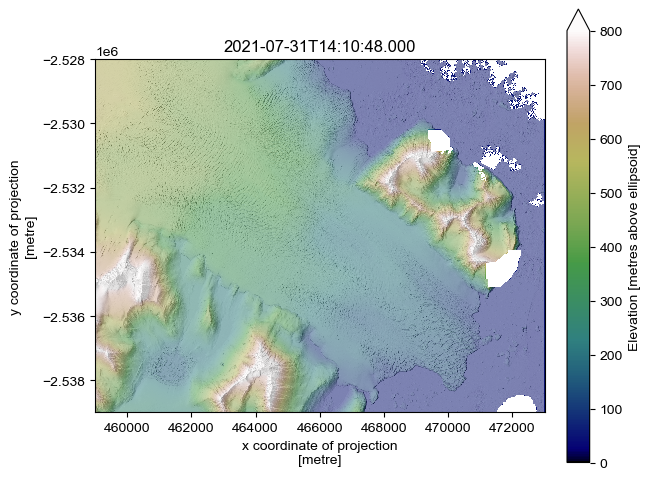

In [16]:
fig, ax = plt.subplots(layout='constrained')

dem_1.plot(cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})

hillshade_1.plot(cmap='Greys_r', alpha=.5, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(gdf.iloc[[i]].acqdate1.values[0])
plt.show()

## Coregistration and DEM differencing

Rigorous DEM differencing necessitates coregistering scenes. pDEMtools includes a couple functions to make this quick and easy. Only provides one method of coregistration is provided, that of [Nuth and Kääb (2011)](https://doi.org/10.5194/tc-5-271-2011), which accounts for translation errors only. For further options (e.g. rotation correction), it is worth consulting the [xdem](https://xdem.readthedocs.io/en/latest/coregistration.html) package.

First, we must set a region of stable ground to coregister too. Around Antarctica and Greenland, we can base this on the mask included within BedMachine. The `data.bedrock_mask_from_bedmachine()` function makes this easy:

In [17]:
bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bm_fpath, dem_1)

Then we can coregister `dem_2` against `dem_1` using the `.pdt.coregister()` function. This is based on code used in the [PGC postprocessing pipeline](https://github.com/PolarGeospatialCenter/setsm_postprocessing_python/blob/fd36fd54933ec43f587902a4fdcd1acbd90951c2/lib/scenes2strips.py
), updated to utilise the updated `pdemtools` geomorphometric variable derivation.

In [18]:
dem_2_coreg = dem_2.pdt.coregister(dem_1, bedrock_mask)

Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 5.008943557739258
Planimetric Correction Iteration 2
Offset (z,x,y): -0.506, -5.149, 5.180
Translating: -0.51 Z, -5.15 X, 5.18 Y


/Users/tom/miniforge3/envs/geospatial/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


RMSE = 3.56615948677063
Planimetric Correction Iteration 3
Offset (z,x,y): -0.281, -5.238, 5.126
Translating: -0.28 Z, -5.24 X, 5.13 Y
RMSE = 3.5588386058807373
Planimetric Correction Iteration 4
Offset (z,x,y): -0.276, -5.241, 5.124
Translating: -0.28 Z, -5.24 X, 5.12 Y
RMSE = 3.5588457584381104
RMSE step in this iteration (0.00001) is above threshold (-0.001), stopping and returning values of prior iteration. 
Final offset (z,x,y): -0.281, -5.238, 5.126
Final RMSE = 3.5588386058807373


Sometimes, if one of the DEMs is smaller than the clip region, this can fail. If this is the case, try 'padding' the DEMs with NaN values to the full AOI, e.g.:

```python
dem = dem.rio.pad_box(*bounds, constant_values=np.nan)
```

Let's compare and plot:

In [19]:
dz_coreg = (dem_2_coreg - dem_1)

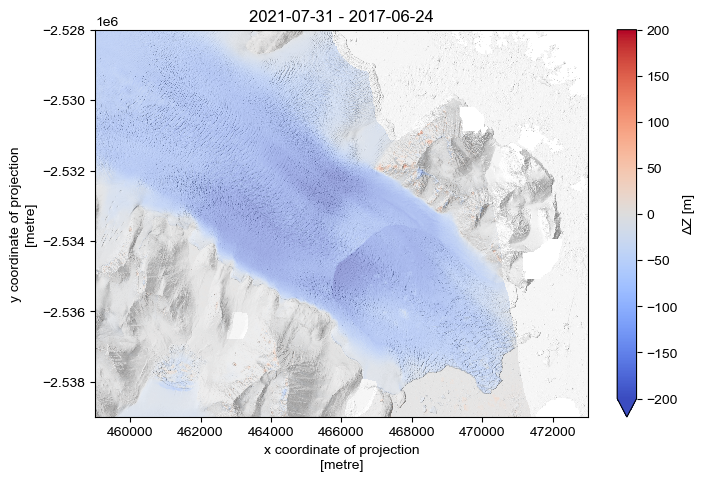

In [20]:
fig, ax = plt.subplots(layout='constrained', figsize=(7,4.7))

vrange = 200
dz_coreg.plot(cmap='coolwarm', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'ΔZ [m]'})
hillshade_1.plot(cmap='Greys_r', alpha=.5, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(f'{gdf_sel.iloc[[1]].acqdate1.dt.date.values[0]} - {gdf_sel.iloc[[0]].acqdate1.dt.date.values[0]}')

plt.savefig(os.path.join('..', 'images', 'example_dem_difference.jpg'), dpi=300)
plt.show()